# Relation between threshold in MS spectra and EIC

Tipically, the threshold in a MS spectra is determined empirically taking into account the instrument SNR. In the same way, an EIC threshold can be defined empirically, but given the relation between the intensity in the spectra and the intensity in an EIC, a less arbitrary threshold can be calculated:

The intensity in an EIC is calculated using the a central value $m_{0}$ and a tolerance $\delta$ in a given spectrum. Thus, the $k$ point in an EIC, is obtained in the following way:

$$I_{EIC}=\int_{m_{0}-\delta}^{m_{0}+\delta}I_{sp}(m) dm$$

To determine a threshold for the EIC we are going to use another common parameter associated with the instrument: the resolution R. The resolution is related with the FWHM of a peak, but is a mass dependent value:

$$ R(m) = \frac{\textrm{FWHM}}{m} $$

If we suppose that the spectral peaks are gaussian with mean $m_{0}$, standard deviation $\sigma$ and amplitude $I_{0}$, then we have the following relations:

$$\textrm{FWHM} = 2\sqrt{2\ln 2}\sigma$$
$$I_{EIC} = I_{0}  \textrm{FWHM} \sqrt{\frac{\pi}{\ln 2}} \left(\textrm{cdf} \left( \frac{2\sqrt{2\ln 2}\delta}{\textrm{FWHM}}\right) - 0.5 \right)$$

Where cdf is the cumulative normal distribution of the standard normal distribution. If we set $I_{0}$ as the spectral threshold, we have threhold for the EIC, that depends only on the tolerance used to build the EICs and the average resolution of the instrument. Looking at the equation we can see that the FWHM has two opposing effects in the threshold value: On one hand, it increments the threshold value because the peak is wider, and in the other hand it decreases the threshold value because a bigger part of the tails of the peak is outside the interval used to build the EIC.

In the following figure we have a a heatmap with values for the EIC threshold for different values of $\delta$ and FWHM using $I_{0}=1$ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import find_peaks
from scipy.integrate import trapz

In [2]:
delta = np.arange(0.01, 0.1, 0.01)
fwhm = delta


def threshold_grid(x, y):
    result = np.zeros((y.size, x.size))
    for col, xx in enumerate(x):
        for row, yy in enumerate(y):
            result[row, col] = get_eic_threshold(xx, yy, 1)
    return result


def get_eic_threshold(mz_tol, fwhm, sp_thresh):
    c = 2 * np.sqrt(2 * np.log(2))
    n = norm(scale=fwhm / c)
    return (sp_thresh
            * fwhm
            * np.sqrt(np.pi/np.log(2))
            * (norm.cdf(c * mz_tol / fwhm) - 0.5))


def gauss(x, mu, sigma, amp=None):
    """
    gaussian curve.

    Parameters
    ----------
    x : np.array
    mu : float
    sigma : float
    amp : float / None
        If None returns a normalized gaussian curve.

    Returns
    -------
    gaussian : np.array
    """
    if amp is None:
        amp = 1 / (np.sqrt(2 * np.pi) * sigma)
    gaussian = amp * np.power(np.e, - 0.5 * ((x - mu) / sigma) ** 2)
    return gaussian


hm = threshold_grid(delta, fwhm)

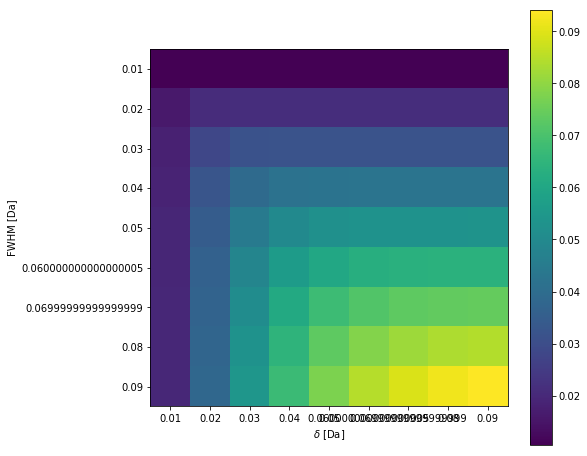

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(hm)
plt.colorbar(im)
ax.set_xticks(np.arange(0, fwhm.size))
ax.set_xticklabels(delta)
ax.set_xlabel("$\delta$ [Da]")
ax.set_yticks(np.arange(0, fwhm.size))
ax.set_yticklabels(fwhm)
ax.set_ylabel("FWHM [Da]");

We see that the influence of $\delta$ is of importance only when $\delta \approx \textrm{FWHM}$ and that for a fixed tolerance, the EIC threshold increases with the $\textrm{FWHM}$. Then, the most permissive threshold is obtained when the highest possible resolution (or the smallest FWHM) is used.
For a Q-TOF a resolution of 50000 at 500 Da is equivalent to a **FWHM of 0.01**. If we set a **spectral threshold of 1000**, then the following values are obtained 

In [4]:


fwhm = 0.01
amp = 1000
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
# simulated gaussian peak used to estimate the peak area
x = np.linspace(-0.1, 0.1, num=7000)
y = gauss(x, 0, sigma, amp=amp)
area = trapz(y, x)
eic_thresh = get_eic_threshold(0.05, 0.01, 1000)
print("Peak area: ", area)
print("EIC threshold: ", eic_thresh)

Peak area:  10.644670194312264
EIC threshold:  10.644670194312262


(-0.025, 0.025)

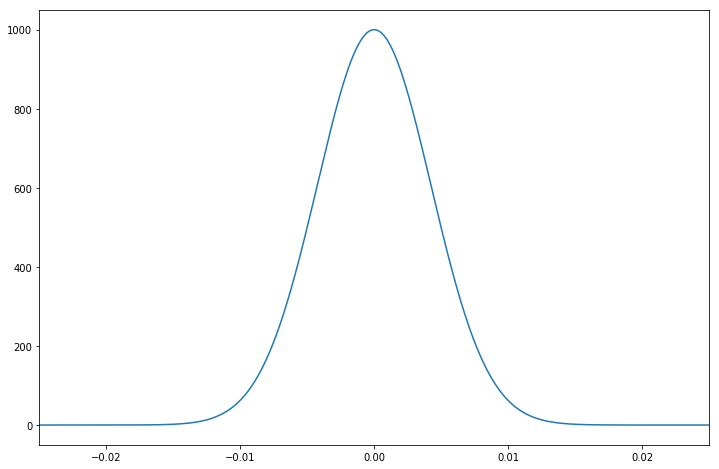

In [37]:
peaks, props = find_peaks(y, width=3, rel_height=0.5)
widths = peak_widths(y, peaks, rel_height=0.5)

fig, ax = plt.subplots(figsize=(12, 8))
line = ax.plot(x, y)
#l2 = ax.plot([-0.015, 0.015], [500, 500])
#l3 = ax.plot([0.005, 0.005], [400, 600])
#l4 = ax.plot([-0.005, -0.005], [400, 600])
lt = plt.hlines(*widths[1:])
ax.set_xlim(-0.025, 0.025)

In [38]:
widths

(array([349.95197973]),
 array([499.99717003]),
 array([3324.52401013]),
 array([3674.47598987]))

In [24]:
peaks

array([3499])

In [26]:
from scipy.signal import peak_widths

array([3674.47598987])